# 这是一个建立各种机器学习模型的测试程序

## 载入相关库

In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score

from scipy import interp
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

## 载入数据（特征+标签）

In [2]:
data = pd.read_csv("./DataSets/features.dat",header=None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.002690,0.002630,0.002743,0.002506,0.002737,0.002791,0.002590,0.002726,0.002484,0.002841,...,-0.002815,0.000849,0.001611,-0.000375,-0.000097,0.000300,-0.000327,-0.000777,0.000558,-0.001546
1,0.002719,0.002617,0.002737,0.002715,0.002794,0.002601,0.002636,0.002523,0.002591,0.002842,...,-0.000097,0.000300,-0.000327,-0.000777,0.000558,-0.001546,0.000802,-0.000707,-0.001041,0.001237
2,0.003065,0.002631,0.002710,0.002841,0.002624,0.002595,0.002575,0.002562,0.002568,0.002805,...,0.000558,-0.001546,0.000802,-0.000707,-0.001041,0.001237,0.000635,-0.001843,0.000294,0.004381
3,0.002838,0.002867,0.002596,0.002727,0.002702,0.002556,0.002524,0.002426,0.002515,0.002871,...,-0.001041,0.001237,0.000635,-0.001843,0.000294,0.004381,-0.002215,0.000085,-0.000257,0.000111
4,0.002715,0.002743,0.002506,0.002737,0.002791,0.002590,0.002726,0.002484,0.002841,0.002876,...,0.000294,0.004381,-0.002215,0.000085,-0.000257,0.000111,-0.001733,0.000205,0.000983,-0.000687


In [4]:
 data.shape

(20536, 61)

In [5]:
labels = pd.read_csv("./DataSets/labels.dat",header=None)

In [6]:
labels.shape

(20536, 1)

## 数据预处理，划分数据集，归一化

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
         data, labels, test_size=0.3, random_state=0)

In [51]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## 感知器

In [36]:
ppn = Perceptron(max_iter=50, eta0=0.1, random_state=0,n_jobs=4)
ppn.fit(X_train_std, y_train.values.ravel())

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      max_iter=50, n_iter=None, n_jobs=4, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [32]:
y_pred = ppn.predict(X_test_std)
# print('错误分类的样本: %d' % ((y_test != y_pred).sum()))
print('准确率: %.2f' % accuracy_score(y_test, y_pred))

准确率: 0.83


### K折交叉验证

In [35]:
scores = cross_val_score(estimator=ppn, 
                         X=data.values, 
                         y=labels.values.ravel(), 
                         cv=5)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.8105007  0.78504348 0.77982609 0.82226087 0.85003479]
CV accuracy: 0.810 +/- 0.026


## LR(逻辑回归)

In [51]:
lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train.values.ravel())

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [52]:
y_pred2 = lr.predict(X_test_std)
print('准确率: %.2f' % accuracy_score(y_test, y_pred2))

准确率: 0.84


### K折交叉验证

In [53]:
scores = cross_val_score(estimator=lr, 
                         X=data.values, 
                         y=labels.values.ravel(), 
                         cv=5)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.84840056 0.85530435 0.8413913  0.84382609 0.85212248]
CV accuracy: 0.848 +/- 0.005


### 模型评估（绘制ROC曲线和AUC面积）

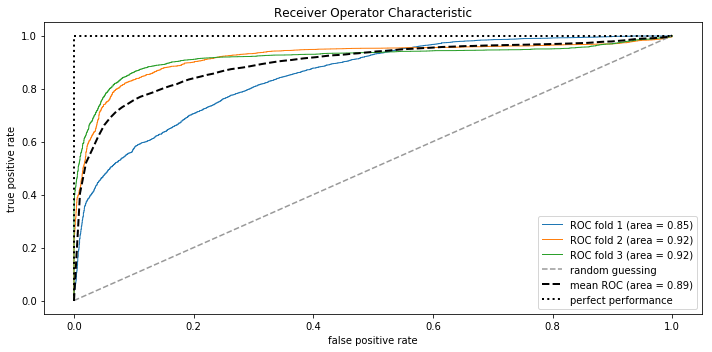

In [102]:
cv = StratifiedKFold(n_splits=3)
fig = plt.figure(figsize=(10, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv.split(data, labels)):
    probas = lr.fit(data.values[train], labels.values[train].ravel()).predict_proba(data.values[test])
    
    # 计算ROC曲线和曲线区域
    fpr, tpr, thresholds = roc_curve(labels.values[test], 
                                     probas[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    
    mean_tpr[0] = 0.0
    
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, 
             tpr, 
             lw=1, 
             label='ROC fold %d (area = %0.2f)' 
                    % (i+1, roc_auc))
    
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         color=(0.6, 0.6, 0.6), 
         label='random guessing')

mean_tpr /= i+1
# mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], 
         [0, 1, 1], 
         lw=2, 
         linestyle=':', 
         color='black', 
         label='perfect performance')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()

In [104]:
pipe_svc = lr.fit(X_train_std, y_train.values.ravel())
y_pred2 = lr.predict(X_test_std)
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.749
Accuracy: 0.697


## SVM

In [12]:
svm = SVC(kernel='linear', C=100.0,gamma=100.0, random_state=0)
svm.fit(X_train_std, y_train.values.ravel())

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100.0, kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
y_pred3 = svm.predict(X_test_std)
print('准确率: %.2f' % accuracy_score(y_test, y_pred3))

准确率: 0.85


### K折交叉验证

In [15]:
scores = cross_val_score(estimator=svm, 
                         X=data.values, 
                         y=labels.values.ravel(), 
                         cv=3)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.77227578 0.84733382 0.87611395]
CV accuracy: 0.832 +/- 0.044


## kernel SVM

In [16]:
ksvm = SVC(kernel='rbf', random_state=0, gamma=10.0, C=100.0)
ksvm.fit(X_train_std, y_train.values.ravel())

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
y_pred4 = ksvm.predict(X_test_std)
print('准确率: %.2f' % accuracy_score(y_test, y_pred4))

准确率: 0.94


### K折交叉验证

In [19]:
scores = cross_val_score(estimator=ksvm, 
                         X=data.values, 
                         y=labels.values.ravel(), 
                         cv=3,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.90870581 0.94726077 0.94711468]
CV accuracy: 0.934 +/- 0.018


### 网格搜索

In [22]:
param = {"gamma":[0.01,0.1,1,10,100],
             "C":[0.01,0.1,1,10,100]}

In [23]:
grid_search = GridSearchCV(SVC(kernel='rbf',random_state=0),n_jobs=-1,param_grid=param,cv=3,refit='AUC',return_train_score=True)

In [26]:
%time grid_search.fit(X_train_std, y_train.values.ravel())

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 17min 57s


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.01, 0.1, 1, 10, 100], 'C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
grid_search.best_score_

0.9682782608695653

In [29]:
pd.DataFrame(grid_search.cv_results_).T

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are acc

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
mean_fit_time,19.966,15.1371,26.3067,44.1696,55.2653,12.2483,8.37407,22.1552,38.6768,58.1025,...,5.8138,3.72614,21.937,61.1921,88.9129,4.66577,3.55262,19.5507,54.3746,77.7482
std_fit_time,0.260116,0.286387,0.357297,1.07925,1.31338,0.48577,0.296241,0.151019,5.60874,0.749442,...,0.0816975,0.110919,2.90254,0.566498,3.6962,0.0329295,0.179281,4.09702,0.598503,2.30193
mean_score_time,6.51417,5.28134,8.49896,11.1509,14.5454,4.18054,2.38481,7.01459,10.2168,12.6683,...,1.25368,0.705425,6.17334,9.96431,11.6518,0.752429,0.501563,5.11066,8.67678,9.09448
std_score_time,0.0732122,0.253345,0.151998,0.154912,0.592961,0.148141,0.0712965,0.160958,0.51061,0.240406,...,0.171238,0.0438635,0.308693,0.203249,0.151433,0.011245,0.0205736,0.142252,0.0698625,0.693187
param_C,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,...,10,10,10,10,10,100,100,100,100,100
param_gamma,0.01,0.1,1,10,100,0.01,0.1,1,10,100,...,0.01,0.1,1,10,100,0.01,0.1,1,10,100
params,"{'C': 0.01, 'gamma': 0.01}","{'C': 0.01, 'gamma': 0.1}","{'C': 0.01, 'gamma': 1}","{'C': 0.01, 'gamma': 10}","{'C': 0.01, 'gamma': 100}","{'C': 0.1, 'gamma': 0.01}","{'C': 0.1, 'gamma': 0.1}","{'C': 0.1, 'gamma': 1}","{'C': 0.1, 'gamma': 10}","{'C': 0.1, 'gamma': 100}",...,"{'C': 10, 'gamma': 0.01}","{'C': 10, 'gamma': 0.1}","{'C': 10, 'gamma': 1}","{'C': 10, 'gamma': 10}","{'C': 10, 'gamma': 100}","{'C': 100, 'gamma': 0.01}","{'C': 100, 'gamma': 0.1}","{'C': 100, 'gamma': 1}","{'C': 100, 'gamma': 10}","{'C': 100, 'gamma': 100}"
split0_test_score,0.810309,0.901085,0.88919,0.804257,0.620618,0.894616,0.945952,0.940526,0.875835,0.772538,...,0.951377,0.971202,0.968698,0.935935,0.861853,0.959933,0.968072,0.964942,0.935935,0.861853
split1_test_score,0.809265,0.901711,0.884599,0.80697,0.622496,0.894825,0.941569,0.931135,0.876043,0.775459,...,0.946995,0.962229,0.969324,0.932179,0.86081,0.952212,0.965568,0.965985,0.931761,0.86081
split2_test_score,0.813191,0.899603,0.882279,0.801085,0.621165,0.89355,0.9378,0.932164,0.86579,0.77249,...,0.945732,0.96723,0.966813,0.930495,0.85598,0.959716,0.96556,0.962221,0.92966,0.85598


In [30]:
y_pred10 = grid_search.predict(X_test_std)
print('准确率: %.2f' % accuracy_score(y_test, y_pred10))

准确率: 0.97


### 使用三维点图绘制C和gamma和AUC之间的关系

In [33]:
C_val = []
for i in range(0,25):
    C_val.append(grid_search.cv_results_["params"][i]["C"])
#C_val
#np.array(C_val)

In [35]:
gamma_val = []
for i in range(0,25):
    gamma_val.append(grid_search.cv_results_["params"][i]["gamma"])
#gamma_val
#np.array(gamma_val)

In [36]:
#for i in range(0,36):
    #print(grid_search.cv_results_["mean_test_score"][i])
AUC_score = grid_search.cv_results_["mean_test_score"]
#AUC_score

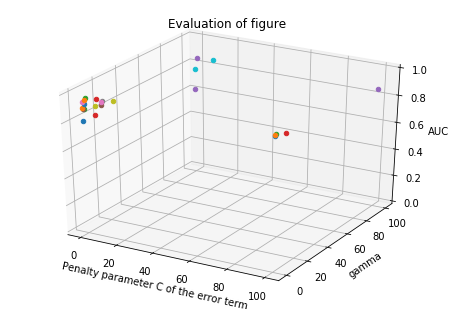

In [37]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)


X = C_val
Y = gamma_val
Z = AUC_score
#X, Y = np.meshgrid(X, Y)

#print(X)
#print(Y)
#print(Z)

#ax.plot_surface(X, Y, Z,cmap='rainbow')

for x,y,z in zip(X,Y,Z):
    #print(x,y,z)
    #ax.scatter(x, y, z, cmap='rainbow')
    ax.scatter(x, y, z, cmap='rainbow')


plt.title("Evaluation of figure")
ax.set_xlabel('Penalty parameter C of the error term')
#ax.set_xlim(0.001, 10)
ax.set_ylabel('gamma')
#ax.set_ylim(0.001, 10)
ax.set_zlabel('AUC')
ax.set_zlim(0, 1)

plt.show()

### 遍历参数

In [ ]:
for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        ksvm = SVC(kernel='rbf',gamma=gamma,C=C)
        scores = cross_val_score(ksvm,X_train,y_train,cv=5)
        score = scores.mean()
        print("gamma / C / score:",gamma,C,score)

## 决策树

In [55]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)
tree.fit(X_train_std, y_train.values.ravel())

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [56]:
y_pred5 = tree.predict(X_test_std)
print('准确率: %.2f' % accuracy_score(y_test, y_pred5))

准确率: 0.97


### K折交叉验证

In [41]:
scores = cross_val_score(estimator=tree, 
                         X=data.values, 
                         y=labels.values.ravel(), 
                         cv=3)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.95427987 0.95193572 0.96128561]
CV accuracy: 0.956 +/- 0.004


## 随机森林

In [64]:
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10,
                                random_state=1,
                                n_jobs=-1)


In [66]:
forest.fit(X_train_std, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [67]:
y_pred6 = forest.predict(X_test_std)
print('准确率: %.2f' % accuracy_score(y_test, y_pred6))

准确率: 0.98


### K折交叉验证

In [68]:
scores = cross_val_score(estimator=forest, 
                         X=data.values, 
                         y=labels.values.ravel(), 
                         cv=3)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.97180836 0.95821768 0.97399562]
CV accuracy: 0.968 +/- 0.007


## KNN

In [59]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski',n_jobs=-1)
knn.fit(X_train_std, y_train.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [60]:
y_pred7 = knn.predict(X_test_std)
print('准确率: %.2f' % accuracy_score(y_test, y_pred7))

准确率: 0.96


### K折交叉验证

In [61]:
scores = cross_val_score(estimator=knn, 
                         X=data.values, 
                         y=labels.values.ravel(),  
                         cv=3)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.87540169 0.89408327 0.93075237]
CV accuracy: 0.900 +/- 0.023
